In [1]:
import pandas as pd
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta

def logistic_model(x, a, b, c):
    return c / (1 + np.exp(-(x - b) / a))
def exponential_model(x, a, b, c):
    return a * np.exp( b * (x - c))

# Datos
df_original = pd.read_csv("https://covid.ourworldindata.org/data/total_cases.csv")

# arguments
country = "Spain"
first_day = datetime.strptime('2020-01-01', '%Y-%m-%d')
p0_log = [5, 20, 40000]
p0_exp = [0.5, 0.5, 0.5]

Se selecciona el país puesto en `country` y se crea una columna `days`que indica los días que han transcurrido desde el 1 de enero. Luego se crean `x` e `y` como listas de las columnas `days` y los casos del país, respectivamente.

In [2]:
df = df_original
df = df[['date', country]]
df = df[True != df[country].isna()]
df = df.assign(days = df['date'].map(lambda x : (datetime.strptime(x, '%Y-%m-%d') - first_day).days))
x = list(df.iloc[:, 2])
y = list(df.iloc[:, 1])

In [3]:
x

[31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76]

In [4]:
y

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 12.0,
 25.0,
 32.0,
 45.0,
 45.0,
 114.0,
 151.0,
 198.0,
 257.0,
 374.0,
 430.0,
 589.0,
 1024.0,
 1639.0,
 2140.0,
 2965.0,
 4231.0,
 5753.0,
 7753.0,
 9191.0]

Luego se utiliza la función creada de `logistic_curve` con `curve_fit`, pero lo que no en entiendo es realmente qué hace.

Deduzco que en el parámetro `p0`, el contenido de `p0_log` equivale a:

$$
\frac{40000}{1 + e^{-(x - 20)/5}}
$$

pero no entiendo bien por qué esos parámetros.

In [5]:
fit = curve_fit(logistic_model, xdata=x, ydata=y, p0=p0_log, maxfev=2000)
a, b, c = fit[0]
errors = np.sqrt(np.diag(fit[1]))

In [6]:
a

2.3756771398815655

In [7]:
b

75.60509918700934

In [8]:
c

17189.694432221968

Luego con la función `fsolve` no sé realmente qué hace porque le indica que resuelva `logistic_model` como argumento principal `b`, de tal forma que queda

$$
\frac{17189.69}{1 + e^{-(75.60 - 75.60)/2.37}} - 17189.69 = \frac{17189.69}{1 + e^{0}} - 17189.69
$$

pero no entiendo por qué se tiene que resolver a través de `b`.

In [9]:
sol = int(fsolve(lambda z : logistic_model(z, a, b, c) - int(c), b))
last_day = datetime.strftime(first_day + timedelta(days=sol), '%Y-%m-%d')

Al final, con `sol` ya se determinan los días de predicción. Supongo que la clave está de hecho en que `b` corresponda a los días, pero no estoy seguro.

In [10]:
print("Last day of infections : ", last_day , " (approximately)")

Last day of infections :  2020-04-09  (approximately)


In [11]:
exp_fit = curve_fit(exponential_model, x, y, p0=p0_exp)
pred_x = list(range(max(x), sol))

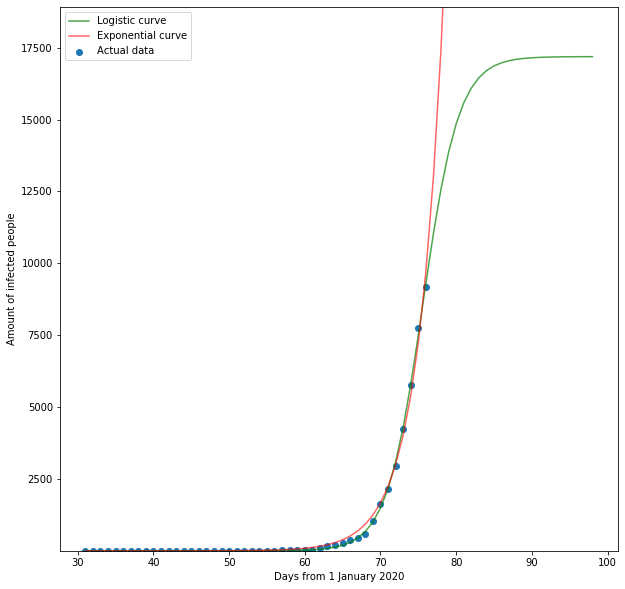

In [12]:
fig = plt.figure(figsize = (10, 10))
plt.scatter(df.iloc[:, 2], df.iloc[:, 1], label='Actual data')
plt.plot(x+pred_x, [logistic_model(i,fit[0][0],fit[0][1],fit[0][2]) for i in x+pred_x], label="Logistic curve", alpha=0.7, color="green")
plt.plot(x+pred_x, [exponential_model(i,exp_fit[0][0],exp_fit[0][1],exp_fit[0][2]) for i in x+pred_x], label="Exponential curve",alpha=0.6, color = "red")
plt.legend()
plt.xlabel("Days from 1 January 2020")
plt.ylabel("Amount of infected people")
plt.ylim((min(y)*0.9,c*1.1))
plt.show()